In [ ]:
%matplotlib inline
import os
import cPickle as pkl
from common.h5py_data_loader import H5pyDataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from itertools import combinations

In [ ]:
##### Filesystem handler functions #####

def get_env_var(handle):
    """Get an environment variable given the handle for the bash variable
    
    Params
    ========
    handle : str
        handle for a bash variable
        
    Returns
    ========
    tmp : str
        environment variable as a string
    """ 
    tmp = os.getenv(handle)
    if not tmp:
        raise LookupError("Environment variable: {} not set.".format(handle))
    return tmp.strip("'")

In [ ]:
def get_kfold_dataloader(dset, kfold_file):
    return H5pyDataLoader(hdf5_file=dataset, target_map_file=None, train_percentage=None, test_indices_file=kfold_file)

In [ ]:
expt_base="{}/20180525_DM_scrubbing/train_data".format(get_env_var("DATA_SAVE_BASE"))
dataset = "{}/train_ts2012_chembl20_MWmax800_scrubDM_minpos10_cutoff5.hdf5".format(expt_base)

In [ ]:
dl = H5pyDataLoader(hdf5_file=dataset, target_map_file=None, train_percentage=None)

In [ ]:
dl.load_training_data()

In [ ]:
a = dl.all_act

In [ ]:
np.sum(~np.isnan(a))

In [ ]:
kfold_dir = "{}/20190410_SMA_Investigation/kfold_indices".format(get_env_var("DATA_SAVE_BASE"))

In [ ]:
n_folds=5
fold_list = np.arange(0,n_folds,1)
kfold_file = "{}/pickleKF_{}_indices".format(kfold_dir, {})

for i in fold_list:
    dl_i = get_kfold_dataloader(dataset, kfold_file.format(i))
    # assert each fold has no overlap
    assert(np.size(np.intersect1d(dl_i.train_indices, dl_i.test_indices)) == 0)
    # assert sum matches full dset size
    dl_i_test_len = len(dl_i.test_indices)
    dl_i_train_len = len(dl_i.train_indices)
    dl_full_len = len(dl.train_indices)
    # full size of dataset contained in train and test indices
    assert(dl_full_len == (dl_i_test_len + dl_i_train_len))
    test_ratio = dl_i_test_len/np.float((dl_i_test_len + dl_i_train_len))
    # test set size is 5-fold size
    assert(test_ratio == 1/float(n_folds))
    
for fold_i, fold_j in combinations(fold_list, 2):
    dl_i = get_kfold_dataloader(dataset, kfold_file.format(fold_i))
    dl_j = get_kfold_dataloader(dataset, kfold_file.format(fold_j))
    # assert no overlap
    assert(np.size(np.intersect1d(dl_i.test_indices, dl_j.test_indices)) == 0)

In [ ]:
test_activities = dl_i.load_activity()[dl_i.test_indices]
train_activities = dl_i.load_activity()[dl_i.train_indices]

# Distribution differences between train and test for molecules in each fold

In [ ]:
for i in fold_list:
    dl_i = get_kfold_dataloader(dataset, kfold_file.format(i))
    test_activities = dl_i.load_activity()[dl_i.test_indices]
    train_activities = dl_i.load_activity()[dl_i.train_indices]
    g = sns.distplot(test_activities[~np.isnan(test_activities)], label="test", kde=True, hist=False, color="red")
    g = sns.distplot(train_activities[~np.isnan(train_activities)], label="train", kde=True, hist=False, color="blue")
    g.set_title("Plot for fold {}".format(i))
    plt.show()

## Check that the general trends over targets are upheld (qualitative)

In [ ]:
for i in fold_list:
    dl_i = get_kfold_dataloader(dataset, kfold_file.format(i))
    test_pos = dl_i.load_pos()[dl_i.test_indices]
    train_pos = dl_i.load_pos()[dl_i.train_indices]
    test_activities = dl_i.load_activity()[dl_i.test_indices]
    train_activities = dl_i.load_activity()[dl_i.train_indices]
    plt.subplots(figsize=(15,10))
    g = sns.distplot(test_pos[~np.isnan(test_activities)], label="test",
                     kde=False, hist=True, color="red",)
    g = sns.distplot(train_pos[~np.isnan(train_activities)], label="train", 
                     kde=False, hist=True, color="blue",)
    g.set_title("Plot for fold {}".format(i))
    g.set_xlim((0, dl_i.num_targets))
    plt.show()

## Re-plot of distribution of molecules but with histograms

In [ ]:
for i in fold_list:
    dl_i = get_kfold_dataloader(dataset, kfold_file.format(i))
    test_activities = dl_i.load_activity()[dl_i.test_indices]
    train_activities = dl_i.load_activity()[dl_i.train_indices]
    g = sns.distplot(test_activities[~np.isnan(test_activities)], label="test", kde=False, hist=True, color="red")
    g = sns.distplot(train_activities[~np.isnan(train_activities)], label="train", kde=False, hist=True, color="blue")
    g.set_title("Plot for fold {}".format(i))
    plt.show()

## make data to compare molecule counts between test and train sets

In [ ]:
df1 = pd.DataFrame({"fold": [], "test_pos":[], "targ":[]})
df2 = pd.DataFrame({"fold":[], "train_pos":[], "targ":[]})
for i in fold_list:
    dl_i = get_kfold_dataloader(dataset, kfold_file.format(i))
    
    test_activities = dl_i.load_activity()[dl_i.test_indices]
    train_activities = dl_i.load_activity()[dl_i.train_indices]
    
    test_pos = dl_i.load_pos()[dl_i.test_indices]
    train_pos = dl_i.load_pos()[dl_i.train_indices]
    
    m_test = ~np.isnan(test_activities)
    m_train = ~np.isnan(train_activities)
    
    test_targ_list = test_pos[m_test]
    test_act_list = test_activities[m_test]
    
    train_targ_list = train_pos[m_train]
    train_act_list = train_activities[m_train]
    
    assert(test_targ_list.shape == test_act_list.shape)
    assert(train_targ_list.shape == train_act_list.shape)
    
    test_df =  pd.DataFrame({"fold": [i]*test_targ_list.shape[0], 
                             "test_pos": test_act_list>5.0, 
                             "targ": test_targ_list })
    train_df =  pd.DataFrame({"fold": [i]*train_targ_list.shape[0], 
                             "train_pos": train_act_list>5.0, 
                             "targ": train_targ_list }) 
    
    df1 = pd.concat([df1, test_df])
    df2 = pd.concat([df2, train_df])
    
df1["test_mols"] = 1
df2["train_mols"] = 1

df1 = df1.groupby(["fold", "targ"]).sum()
df2 = df2.groupby(["fold", "targ"]).sum()

merged = df1.merge(df2, on=["fold", "targ"])

df1 = df1.reset_index()
df2 = df2.reset_index()
merged = merged.reset_index()

## Which targets are missing molecules in test sets?

In [ ]:
for i in np.arange(0, n_folds, 1):
    # Get unique targets per fold
    targs1 = [int(j) for j in df1[df1.fold == i].targ.unique()]
    targs2 = [int(j) for j in df2[df2.fold == i].targ.unique()]
    
    print("Targets missing test set molecules in fold {}".format(i))
    # print targets in the train set that aren't in the test set
    missing = np.setdiff1d(targs2, targs1)
    print(df2[(df2.targ.isin(missing)) & (df2.fold == i)])
    print(df1[(df1.targ.isin(missing)) & (df1.fold == i)])

In [ ]:
missing = np.setdiff1d(targs2, targs1)

In [ ]:
df2[(df2.targ.isin(missing)) & (df2.fold == i)]

## print distribution of positive:total molecules in test set sized by number of molecules in train set


In [ ]:
# print distribution of positive:total molecules in test set sized by number of molecules in train set
colors = sns.color_palette("husl", n_folds)
for i in np.arange(0, n_folds, 1):
    tmp_df = merged[merged["fold"] == i]
    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(15,12))
    g = sns.scatterplot(x="test_mols", y="test_pos", 
                size="train_mols", 
                color = colors[i],
                alpha=.3, 
                data=tmp_df,
                sizes=(50,900),
                ax=ax)
    ax.set_xscale('log', basex=10)
    ax.set_ylim((0.5,1500))
    ax.set_yscale('log', basey=10)
    ax.legend(loc=2, title="Number of Molecules in the Train Set")
    ax.set_ylabel("Number of Positive Molecules in Test Set")
    ax.set_xlabel("Number of Total Molecules in Test Set")
    g.set_title("Fold {} ".format(i))
    plt.show()

## print distribution of positive:total molecules in test set sized by number of molecules in train set


In [ ]:
# print distribution of positive:total molecules in train set sized by number of molecules in test set

colors = sns.color_palette("husl", n_folds)
for i in np.arange(0, n_folds, 1):
    tmp_df = merged[merged["fold"] == i]
    sns.set_context("talk")
    fig, ax = plt.subplots(figsize=(15,12))
    g = sns.scatterplot(x="train_mols", y="train_pos", 
                size="test_mols", 
                color = colors[i],
                alpha=.3, 
                data=tmp_df,
                sizes=(50,900),
                ax=ax)
    ax.set_xscale('log', basex=10)
#     ax.set_ylim((0.5,))
    ax.set_yscale('log', basey=10)
    ax.legend(loc=2, title="Number of Molecules in the Test Set")
    ax.set_ylabel("Number of Positive Molecules in Train Set")
    ax.set_xlabel("Number of Total Molecules in Train Set")
    g.set_title("Fold {} ".format(i))
    plt.show()

## print N for each set

In [15]:
counts_df = merged.groupby("fold").sum().reset_index()
counts_df = counts_df.drop("targ", axis=1)

In [16]:
counts_df.columns

Index([u'fold', u'test_pos', u'test_mols', u'train_pos', u'train_mols'], dtype='object')

In [17]:
total_counts_df_formatted = pd.DataFrame({"fold":[], "value":[], "label": []})
for label in ['test_mols', 'train_mols']:
    tmp_df = counts_df[["fold", label]]
    tmp_df.columns = ["fold", "value"]
    tmp_df["label"] = label
    total_counts_df_formatted = pd.concat([total_counts_df_formatted, tmp_df])

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


In [18]:
pos_counts_df_formatted = pd.DataFrame({"fold":[], "value":[], "label": []})
for label in ['test_pos', 'train_pos']:
    tmp_df = counts_df[["fold", label]]
    tmp_df.columns = ["fold", "value"]
    tmp_df["label"] = label
    pos_counts_df_formatted = pd.concat([pos_counts_df_formatted, tmp_df])

/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/srv/home/ecaceres/anaconda2/envs/features/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  


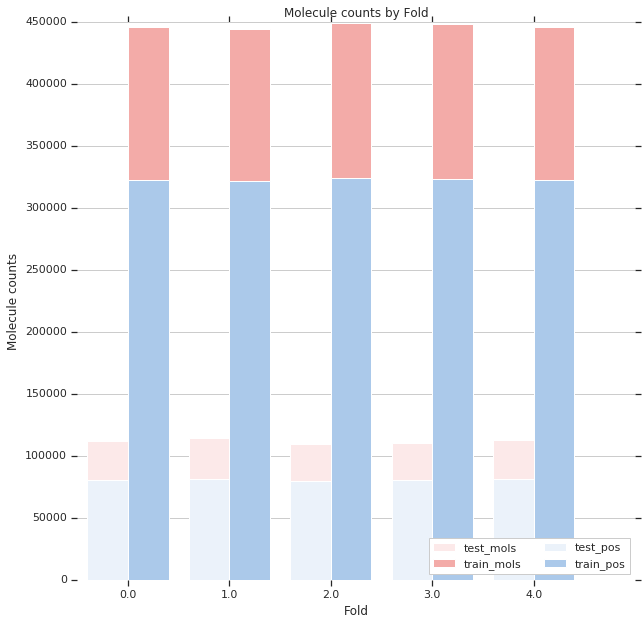

In [19]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total mols
sns.set_color_codes("pastel")
sns.barplot(x="fold", y="value", data=total_counts_df_formatted, hue="label",orient="v",
            color="r")
# Plot the crashes where alcohol was involved
sns.set_color_codes("pastel")
sns.barplot(x="fold", y="value", data=pos_counts_df_formatted, hue="label",orient="v",
            color="b")

# Add a legend and informative axis label
ax.set(ylim=(0, 450000),ylabel="Molecule counts", 
       xlim=(-0.5, 5), xlabel="Fold")
ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 450000),xlabel="Molecule counts", 
#        ylim=(0, 4), ylabel="Fold")
sns.despine(left=True, bottom=True)
ax.set_title("Molecule counts by Fold")

## Percent dataset that's positive

In [20]:
counts_df["ppos_test"] = (counts_df["test_pos"]/counts_df["test_mols"])*100
counts_df["ppos_train"] = (counts_df["train_pos"]/counts_df["train_mols"])*100

In [21]:
counts_df["total_ppos"] = ((counts_df["test_pos"]+ counts_df["train_pos"])/(counts_df["test_mols"] + counts_df["train_mols"]))*100

In [22]:
counts_df["total_mols"] = counts_df["test_mols"] + counts_df["train_mols"]

In [23]:
counts_df

,fold,test_pos,test_mols,train_pos,train_mols,ppos_test,ppos_train,total_ppos,total_mols
0,0.0,80861.0,112202,322355.0,445805,72.067343,72.308521,72.260025,558007
1,1.0,81373.0,114263,321897.0,443815,71.215529,72.529545,72.260508,558078
2,2.0,79566.0,109190,323802.0,448992,72.869310,72.117543,72.264602,558182
3,3.0,80312.0,110186,323029.0,447972,72.887663,72.109194,72.262872,558158
4,4.0,81297.0,112394,322017.0,445729,72.332153,72.245019,72.262566,558123


In [28]:
# check n_examples is the same for test+train...
for i in fold_list:
    dl_i = get_kfold_dataloader(dataset, kfold_file.format(i))
    
    test_activities = dl_i.load_activity()[dl_i.test_indices]
    train_activities = dl_i.load_activity()[dl_i.train_indices]
    
    test_pos = dl_i.load_pos()[dl_i.test_indices]
    train_pos = dl_i.load_pos()[dl_i.train_indices]
    
    m_test = ~np.isnan(test_activities)
    m_train = ~np.isnan(train_activities)
    
    print np.sum(m_test)+np.sum(m_train)
    
    test_targ_list = test_pos[m_test]
    test_act_list = test_activities[m_test]
    
    train_targ_list = train_pos[m_train]
    train_act_list = train_activities[m_train]
    


558235
558235
558235
558235
558235
